In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss, DDPMLoss
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

from NCP.metrics import smooth_cdf

from NCP.cdf import compute_marginal

#import normflows as nf

# diffusion model imports:
from NCP.nn.diffusion_conditional import DDPM, ContextUnet
from NCP.nn.ddpm_module import DDPMModule

import itertools

from NCP.examples.tools.plot_utils import setup_plots
from NCP.examples.tools.data_gen import gen_bimodal, get_conditional_bimodal_cdf, get_conditional_bimodal_pdf
from NCP.examples.tools.lincde import lincde
setup_plots()

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


np.random.seed(0)
torch.manual_seed(0)
Ntrain = 10000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NEXP = 10

#MODELS = ['lincde', 'NN', 'ddpm]
MODELS = ['NN', 'ddpm']

Generating bimodal data as presented in LinCDE (Gao and Hastie). X are 20 dimensional, but only the first 3 dimensions impact Y. 
- the first dimension gives the mean, 
- the second the modality (bi or uni modal) 
- the third the asymetry.

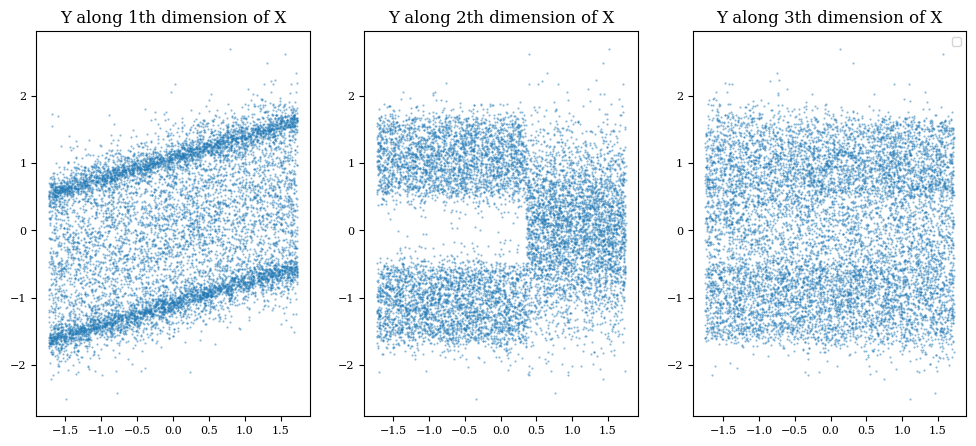

In [22]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_bimodal(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.scatter(X_train[:,i], Y_train, alpha=0.5, s=0.3)
    ax.set_title(f'Y along {i+1}th dimension of X')
    if i == 0 :
        plt.legend(['train', 'val', 'test'])

plt.savefig('figures/dataset_lincde.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 1. training NCP

In [4]:
best_models = {}

for exp in range(NEXP):

    L.seed_everything(exp)

    lr = 1e-3
    gamma = 1e-2
    epochs = int(1e4)
    output_shape = 100

    MLP_kwargs_U = {
        'input_shape': X_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 3,
        'layer_size': [32, 64, 128],
        'dropout': 0.,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    MLP_kwargs_V = {
        'input_shape': Y_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 3,
        'layer_size':[8, 16, 32],
        'dropout': 0,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    optimizer = Adam
    optimizer_kwargs = {
        'lr': lr
        }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'split',
        'gamma': gamma
    }

    reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

    X_train_torch = frnp(X_train)
    Y_train_torch = frnp(Y_train)
    X_val_torch = frnp(X_val)
    Y_val_torch = frnp(Y_val)

    NCP_module = NCPModule(
        reg,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

    train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
    val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[early_stop, checkpoint_callback])

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # recover best model during training
    best_model_dict = torch.load(checkpoint_callback.best_model_path)
    restore_buffers_shape(reg, best_model_dict['state_dict'])
    NCP_module.load_state_dict(best_model_dict['state_dict'])
    best_models[exp] = NCP_module.model

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 912: 100%|██████████| 1/1 [00:00<00:00, 30.38it/s, v_num=110, val_loss=-0.746, train_loss=-1.38]     


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 642: 100%|██████████| 1/1 [00:00<00:00, 32.35it/s, v_num=111, val_loss=-0.586, train_loss=-1.10]    


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 804: 100%|██████████| 1/1 [00:00<00:00, 32.34it/s, v_num=112, val_loss=-0.793, train_loss=-1.42]     


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1115: 100%|██████████| 1/1 [00:00<00:00, 30.38it/s, v_num=113, val_loss=-0.843, train_loss=-1.30]    


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 609: 100%|██████████| 1/1 [00:00<00:00, 28.24it/s, v_num=114, val_loss=-0.557, train_loss=-0.92]     


Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 535: 100%|██████████| 1/1 [00:00<00:00, 30.78it/s, v_num=115, val_loss=-0.592, train_loss=-1.26]      


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1041: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s, v_num=116, val_loss=-0.753, train_loss=-0.995]   


Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 879: 100%|██████████| 1/1 [00:00<00:00, 29.97it/s, v_num=117, val_loss=-0.814, train_loss=-1.17]     


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 873: 100%|██████████| 1/1 [00:00<00:00, 26.98it/s, v_num=118, val_loss=-0.589, train_loss=-1.32]     


Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 772: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s, v_num=119, val_loss=-0.871, train_loss=-1.36]     


# 3. Diffusion models

In [5]:
# based on https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py

#train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=128, shuffle=False)
#val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=128, shuffle=False)
best_models_ddpm = {}

for exp in range(NEXP):
    L.seed_everything(exp)

    ddpm = DDPM(nn_model=ContextUnet(x_dim=X_train.shape[-1], y_dim=Y_train.shape[-1]), betas=(1e-4, 0.02), n_T=400, device=device, drop_prob=0.1)

    ddpm_module = DDPMModule(ddpm,
        optimizer,
        optimizer_kwargs,
        DDPMLoss,
        loss_kwargs)

    checkpoint_callback_vanilla = ModelCheckpoint(monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': int(1e4),
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback_vanilla])

    trainer.fit(ddpm_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    checkpoint_callback_vanilla.best_model_path
    best_model_dict = torch.load(checkpoint_callback_vanilla.best_model_path)
    ddpm_module.load_state_dict(best_model_dict['state_dict'])

    best_models_ddpm[exp] = ddpm_module.model

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 41.78it/s, v_num=120, val_loss=0.467, train_loss=0.441] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s, v_num=120, val_loss=0.467, train_loss=0.441]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 41.78it/s, v_num=121, val_loss=0.365, train_loss=0.380] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s, v_num=121, val_loss=0.365, train_loss=0.380]


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s, v_num=122, val_loss=0.508, train_loss=0.500] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s, v_num=122, val_loss=0.508, train_loss=0.500]


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 43.59it/s, v_num=123, val_loss=1.020, train_loss=1.000] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s, v_num=123, val_loss=1.020, train_loss=1.000]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s, v_num=124, val_loss=0.366, train_loss=0.414] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s, v_num=124, val_loss=0.366, train_loss=0.414]


Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 42.54it/s, v_num=125, val_loss=0.354, train_loss=0.378] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 37.73it/s, v_num=125, val_loss=0.354, train_loss=0.378]


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s, v_num=126, val_loss=0.395, train_loss=0.408] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 25.71it/s, v_num=126, val_loss=0.395, train_loss=0.408]


Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 35.81it/s, v_num=127, val_loss=0.936, train_loss=1.010] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 32.34it/s, v_num=127, val_loss=0.936, train_loss=1.010]


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 35.78it/s, v_num=128, val_loss=0.408, train_loss=0.375] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 32.32it/s, v_num=128, val_loss=0.408, train_loss=0.375]


Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 41.78it/s, v_num=129, val_loss=0.394, train_loss=0.413] 

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s, v_num=129, val_loss=0.394, train_loss=0.413]


In [6]:
from scipy.stats import ecdf

def cdf_from_sample(model:DDPM, x, ys, N=1000):
    samples, _ = model.sample(x, N, device='cpu')
    cdf = ecdf(samples.flatten())
    return cdf.cdf.evaluate(ys)

def pdf_from_sample(model:DDPM, x, ys, N=1000):
    samples, _ = model.sample(x, N, device='cpu')
    pdf = compute_marginal(bandwidth='scott').fit(np.array(samples))
    return pdf(ys)

# 4. Results

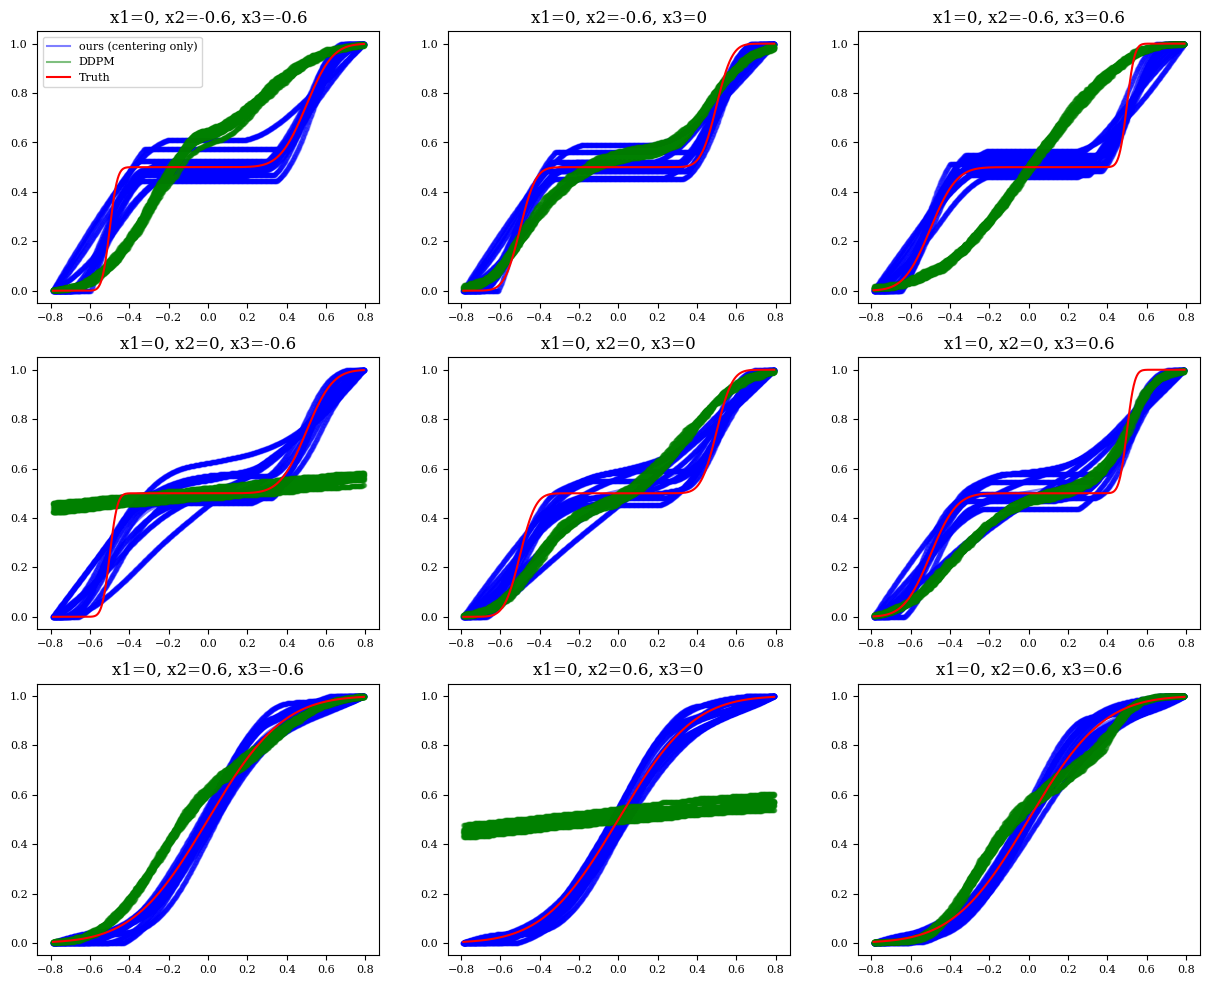

In [23]:
# todo: plot different cdfs, replicate plots from linCDE

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))

    our_cdfs = np.zeros((NEXP, y_discr.shape[0]))
    ddpm_cdfs = np.zeros((NEXP, y_discr.shape[0]))

    for exp in range(NEXP):
        ys, cdf_pred_center = best_models[exp].cdf(x_scaled, y_discr_torch, postprocess='centering')
        our_cdfs[exp] = smooth_cdf(ys, cdf_pred_center)

        fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()

        ddpm_cdfs[exp] = cdf_from_sample(best_models_ddpm[i], x_scaled, ys)

    true_cdf = get_conditional_bimodal_cdf(x, fys)

    #plot all overlapping with alpha 0.2 + mean bolded

    axes[i].plot(fys, our_cdfs.mean(axis=0), '-b',alpha=0.5, label='ours (centering only)')
    for exp in range(NEXP):
        axes[i].plot(fys, our_cdfs[exp], '.b', alpha=0.2)
    #axes[i].fill_between(fys, our_cdfs.mean(axis=0) - 1.96*our_cdfs.std(axis=0), 
    #                     our_cdfs.mean(axis=0) + 1.96*our_cdfs.std(axis=0),
    #                     color='b', alpha=0.3)
    axes[i].plot(fys, ddpm_cdfs.mean(axis=0), '-g', alpha=0.5, label='DDPM')
    for exp in range(NEXP):
        axes[i].plot(fys, ddpm_cdfs[exp], '.g', alpha=0.2)
    #axes[i].fill_between(fys, ddpm_cdfs.mean(axis=0) - 1.96*ddpm_cdfs.std(axis=0), 
    #                     ddpm_cdfs.mean(axis=0) + 1.96*ddpm_cdfs.std(axis=0),
    #                     color='g', alpha=0.3)
    axes[i].plot(fys, true_cdf, 'r', label='Truth')
    
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.savefig('figures/smooth_cdf_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

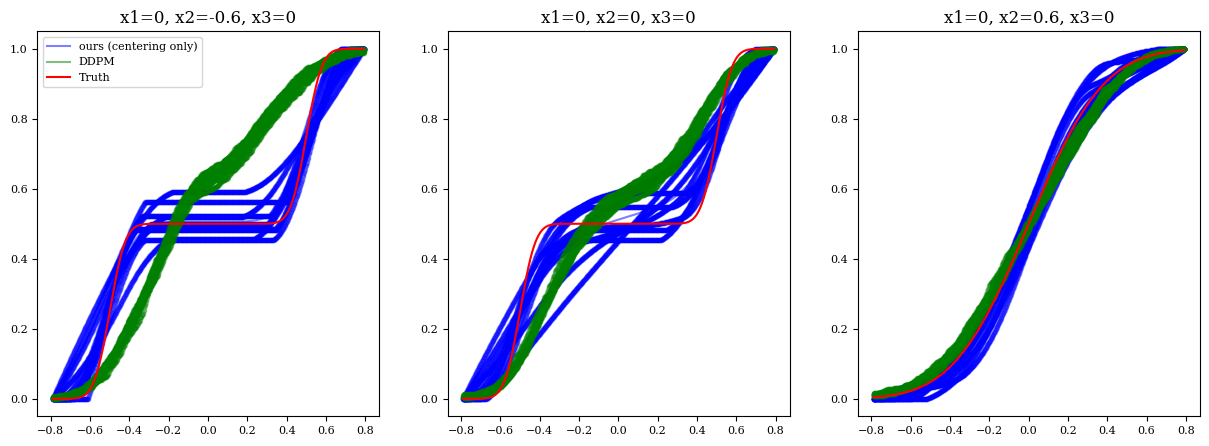

In [24]:
# small version

x1 = [0] # mean
x3 = [ 0] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=(len(x1)*len(x3)), ncols=len(x2), figsize=(15,5))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))

    our_cdfs = np.zeros((NEXP, y_discr.shape[0]))
    ddpm_cdfs = np.zeros((NEXP, y_discr.shape[0]))

    for exp in range(NEXP):
        ys, cdf_pred_center = best_models[exp].cdf(x_scaled, y_discr_torch, postprocess='centering')
        our_cdfs[exp] = smooth_cdf(fys, cdf_pred_center)

        fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()

        ddpm_cdfs[exp] = cdf_from_sample(best_models_ddpm[i], x_scaled, ys)

    true_cdf = get_conditional_bimodal_cdf(x, fys)
    axes[i].plot(fys, our_cdfs.mean(axis=0), '-b',alpha=0.5, markersize=20, label='ours (centering only)')
    for exp in range(NEXP):
        axes[i].plot(fys, our_cdfs[exp], '.b', alpha=0.2, markersize=20)
    #axes[i].fill_between(fys, our_cdfs.mean(axis=0) - 1.96*our_cdfs.std(axis=0), 
    #                     our_cdfs.mean(axis=0) + 1.96*our_cdfs.std(axis=0),
    #                     color='b', alpha=0.3)
    axes[i].plot(fys, ddpm_cdfs.mean(axis=0), '-g', alpha=0.5, label='DDPM')
    for exp in range(NEXP):
        axes[i].plot(fys, ddpm_cdfs[exp], '.g', alpha=0.2)
    #axes[i].fill_between(fys, ddpm_cdfs.mean(axis=0) - 1.96*ddpm_cdfs.std(axis=0), 
    #                     ddpm_cdfs.mean(axis=0) + 1.96*ddpm_cdfs.std(axis=0),
    #                     color='g', alpha=0.3)
    axes[i].plot(fys, true_cdf, 'r', label='Truth')
    
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')
plt.savefig('figures/smooth_cdf_2_small.pdf', format='pdf', bbox_inches='tight')
plt.show()

Should we verify that the other dimensions are independent?

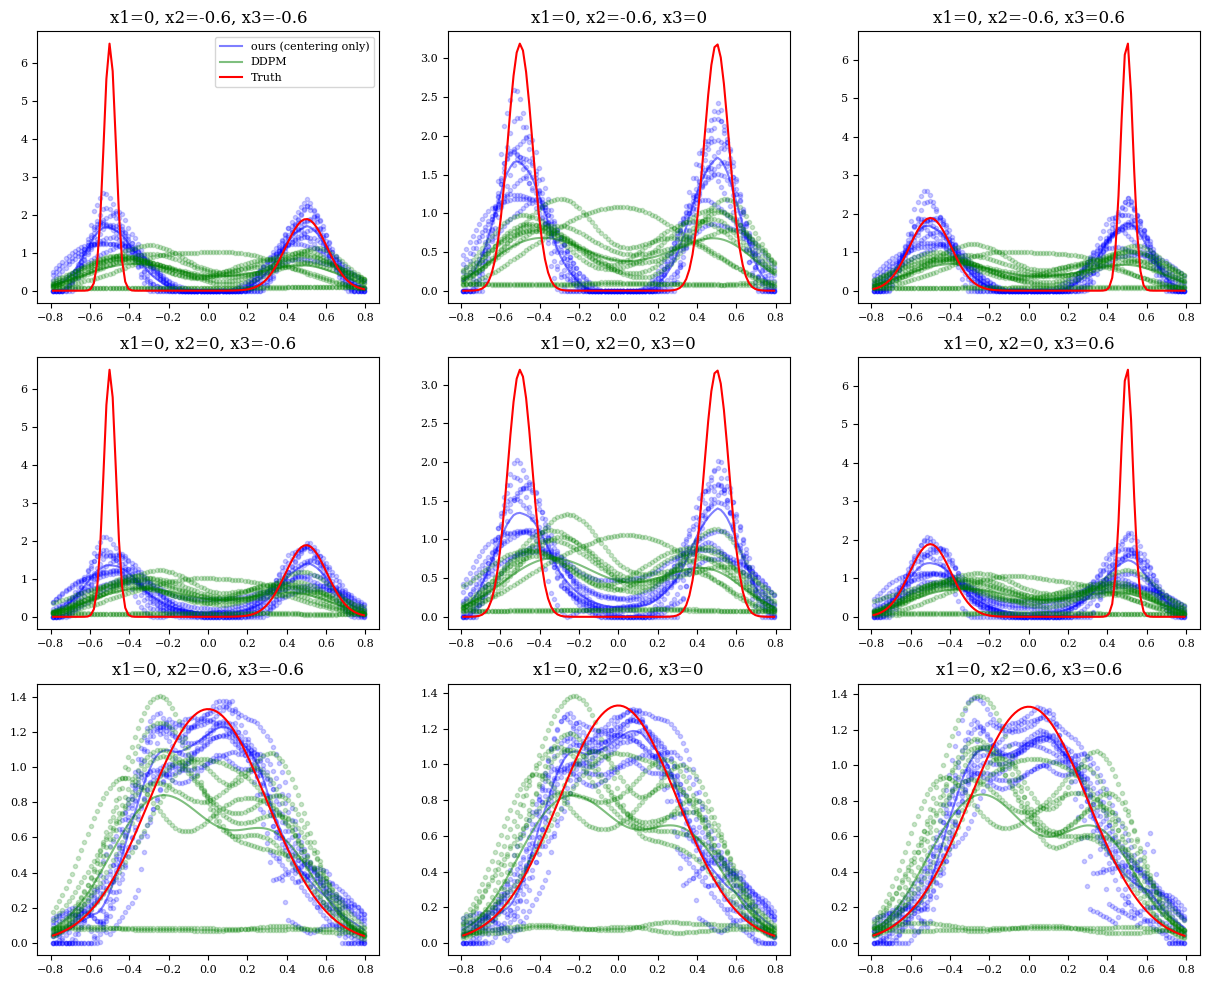

In [25]:
x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=100, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = xscaler.transform([x])
    x_scaled_torch = frnp(x_scaled)

    our_pdfs = np.zeros((NEXP, y_discr.shape[0]))
    ddpm_pdfs = np.zeros((NEXP, y_discr.shape[0]))

    for exp in range(NEXP):

        fys, pdf_pred_center = best_models[exp].pdf(x_scaled_torch, y_discr_torch, p_y=marginal, postprocess='centering')
        pdf_pred_center /= yscaler.scale_
        our_pdfs[exp] = np.maximum(pdf_pred_center, 0) # simple post processing to adress numerical errors

        ddpm_pdfs[exp] = pdf_from_sample(best_models_ddpm[exp], x_scaled_torch, fys)/ yscaler.scale_
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_pdf = get_conditional_bimodal_pdf(x, fys)

    axes[i].plot(fys, our_pdfs.mean(axis=0), '-b',alpha=0.5, label='ours (centering only)')
    for exp in range(NEXP):
        axes[i].plot(fys, our_pdfs[exp], '.b', alpha=0.2)
    #axes[i].fill_between(fys, our_cdfs.mean(axis=0) - 1.96*our_cdfs.std(axis=0), 
    #                     our_cdfs.mean(axis=0) + 1.96*our_cdfs.std(axis=0),
    #                     color='b', alpha=0.3)
    axes[i].plot(fys, ddpm_pdfs.mean(axis=0), '-g', alpha=0.5, label='DDPM')
    for exp in range(NEXP):
        axes[i].plot(fys, ddpm_pdfs[exp], '.g', alpha=0.2)
    #axes[i].fill_between(fys, ddpm_cdfs.mean(axis=0) - 1.96*ddpm_cdfs.std(axis=0), 
    #                     ddpm_cdfs.mean(axis=0) + 1.96*ddpm_cdfs.std(axis=0),
    #                     color='g', alpha=0.3)
    axes[i].plot(fys, true_pdf, 'r', label='Truth')
    
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.savefig('figures/pdf_3.pdf', format='pdf', bbox_inches='tight')
plt.show()

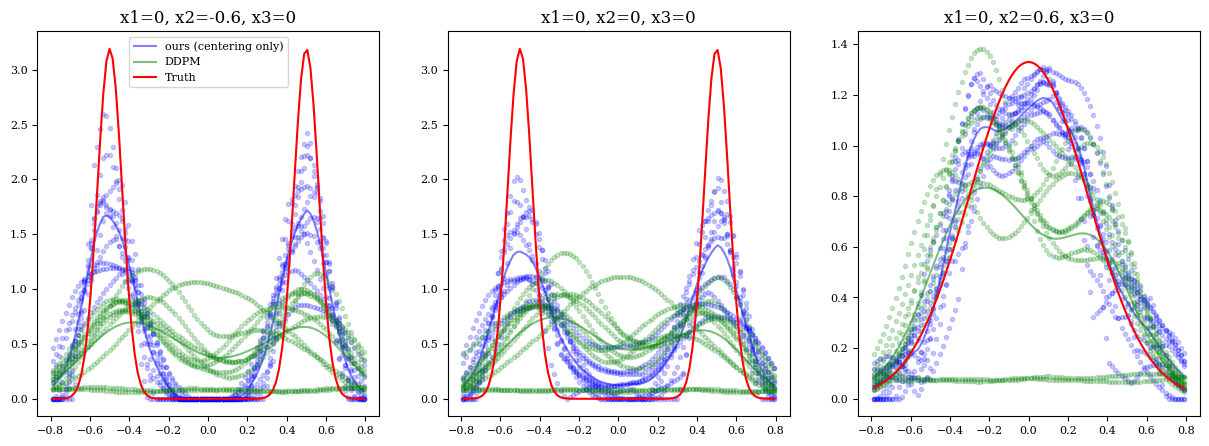

In [26]:
x1 = [0] # mean
x3 = [ 0] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=100, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=(len(x1)*len(x3)), ncols=len(x2), figsize=(15,5))
axes = ax.flatten()

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = xscaler.transform([x])
    x_scaled_torch = frnp(x_scaled)

    our_pdfs = np.zeros((NEXP, y_discr.shape[0]))
    ddpm_pdfs = np.zeros((NEXP, y_discr.shape[0]))

    for exp in range(NEXP):

        fys, pdf_pred_center = best_models[exp].pdf(x_scaled_torch, y_discr_torch, p_y=marginal, postprocess='centering')
        pdf_pred_center /= yscaler.scale_
        our_pdfs[exp] = np.maximum(pdf_pred_center, 0) # simple post processing to adress numerical errors

        ddpm_pdfs[exp] = pdf_from_sample(best_models_ddpm[exp], x_scaled_torch, fys)/ yscaler.scale_
        fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_pdf = get_conditional_bimodal_pdf(x, fys)

    axes[i].plot(fys, our_pdfs.mean(axis=0), '-b',alpha=0.5, label='ours (centering only)')
    for exp in range(NEXP):
        axes[i].plot(fys, our_pdfs[exp], '.b', alpha=0.2)
    #axes[i].fill_between(fys, our_cdfs.mean(axis=0) - 1.96*our_cdfs.std(axis=0), 
    #                     our_cdfs.mean(axis=0) + 1.96*our_cdfs.std(axis=0),
    #                     color='b', alpha=0.3)
    axes[i].plot(fys, ddpm_pdfs.mean(axis=0), '-g', alpha=0.5, label='DDPM')
    for exp in range(NEXP):
        axes[i].plot(fys, ddpm_pdfs[exp], '.g', alpha=0.2)
    #axes[i].fill_between(fys, ddpm_cdfs.mean(axis=0) - 1.96*ddpm_cdfs.std(axis=0), 
    #                     ddpm_cdfs.mean(axis=0) + 1.96*ddpm_cdfs.std(axis=0),
    #                     color='g', alpha=0.3)
    axes[i].plot(fys, true_pdf, 'r', label='Truth')
    if i==0:
        axes[i].legend()

    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.savefig('figures/pdf_2_small.pdf', format='pdf', bbox_inches='tight')
plt.show()

computing metrics

In [ ]:
from NCP.metrics import kullback_leibler, hellinger, wasserstein1, kolmogorov_smirnov

dists = {'kl': kullback_leibler, 'hellinger':hellinger, 'w1':wasserstein1, 'ks':kolmogorov_smirnov}

In [ ]:
x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=100, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

fig, ax = plt.subplots(nrows=(len(x1)*len(x3)), ncols=len(x2), figsize=(15,5))
axes = ax.flatten()

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

true_pdf = get_conditional_bimodal_pdf(x, fys)



for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))

    our_dists = np.zeros((len(dists.keys()), NEXP))
    ddpm_dists = np.zeros((len(dists.keys()), NEXP))

    for exp in range(NEXP):
        ys, cdf_pred_center = best_models[exp].cdf(x_scaled, y_discr_torch, postprocess='centering')
        our_cdf = smooth_cdf(fys, cdf_pred_center)

        fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()

        ddpm_cdf = cdf_from_sample(best_models_ddpm[i], x_scaled, ys)

        for k, dist in dists.items():
            our_dists[]
